# Mapping the duration of inundation according to flow rates <img align="right" src="../Supplementary_data/dea_logo.jpg">
* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[BoM Water Data Online](http://www.bom.gov.au/waterdata/)

## Background
This notebook draws on two previous notebooks [(Inundation_mapping.ipynb and Rising_v_Receding.ipynb)](https://github.com/GeoscienceAustralia/dea-notebooks/commit/1de570546ea47cbfc6ae68c3e25c234ae8b70840), but adds functionality as per a user request. 

The requested functionality: 
1.	Identify peaks above a given threshold
2.	Select all images for X days (say, n=100) after each peak (with an additional condition that they do not rise again to the threshold – i.e. it would reset).
3.	Bin the “after” images into days-after ranges (e.g. 5-10 days after peak, 10-20 days after peak and so on)
4.	Graph each “days since inundation” (noting we can use the geotiffs for further spatial analyses)

## Description
In this example, we take gauge data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage and link it to WOfS data to create a summary image of water frequency according to a user-specified flow rate. 
The worked example demonstrates how to:

1. Take river gauge data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/)
2. User then selects a river gauge to interrogate
    a. Click on a gauge to retrieve a preview of the data
    b. Once you have selected a gauge you want to use, click on 'Done' in the interface
3. Set **analysis parameters** for correlating the stream gauge and satellite data
4. Use Dask loading to link the WOfS dataset to the stream gauge data and plot it
5. Separate the satellite observations by whether they occur on the rising or falling limb of the flood peak and plot it


***

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Load key Python packages and supporting functions for the analysis. This notebook relies on a module called `dea_bom`, which is located in the `Scripts` directory. 

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')
import dea_bom

In [2]:
dc = datacube.Datacube(app='Inundation_mapping')

## Retrieve stream gauge data

This box retrieves data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage using the `dea_bom` module.
We restrict the list of gauges to locations that we have identified as having valid data.

In [3]:
stations_pkl = Path('Supplementary_data/Inundation_mapping/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('Supplementary_data/Inundation_mapping/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]

Loading from cache
4303 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Plot a map of stations and select a gauge that contains data

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it; you can move the map around with the mouse to look for different gauges. Note that after you click on a gauge it can take a second or two to respond. 

When you have the station you want, **click the Done button before moving onto the next box**. If you want to choose a different gauge after having pressed the `Done` button, you must re-run this box to regenerate the map then choose another gauge and press `Done` again. 

> **Note:** If all gauges you click on return "0 observations", this could indicate an issue with fetching data from the BOM webpage. In this case, re-start the notebook and try again later

In [5]:
gauge_data, station = dea_bom.ui_select_station(stations,
                                                zoom=10,
                                                center=(-34.72, 143.17));

## Load in satellite data that corresponds to flood events.

### Analysis parameters

* `buffer`: e.g. 8000 (m). How many metres around the stream gauge do you want to consider? Note that if this parameter becomes too large the notebook can fail due to memory limitations.
* `cloud_threshold`: e.g. 0.3. What percentage of cloud is acceptable within the buffer region per timeslice? e.g. 0.3 means that there must be less than 30% cloud per timestep.
* `low_flow_threshold`: e.g. 300. Looking at the gauge data preview in the cell above, what is the lower threshold of stream gauge heights that you want to consider a flood event. This number should be high enough to remove the low-level noise within the stream gauge.
* `date_range`: e.g. ('1988-01-01', '2019-08-22'). Over what time period do you want to do the analysis. Note that the earliest satellite data is from late 1988, so if you select a date before this, then it will just use data from the earliest available date.

In [6]:
# How many metres around the stream gauge do you want to consider?
buffer = 8000

# Set a cloud masking threshold
cloud_threshold = 0.3

#set threshold for flow rate
low_flow_threshold = 1

#set the analysis date range
date_range = ('1988-01-01', '2019-08-22')

### Run the code to load in satellite observations and link to stream gauge data

In [7]:
lat, lon = station.pos

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': date_range, 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#interpolate the gauge data onto the same timesteps as the wofls
gauge_time_interp = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on where a gauge reading corresponds to a satellite pass
satellite_passes_that_match_gauge_times = gauge_time_interp.where((gauge_time_interp.Value > low_flow_threshold), drop=True)
satellite_passes_that_match_gauge_times = satellite_passes_that_match_gauge_times.drop('Timestamp')
dates_to_load = satellite_passes_that_match_gauge_times.time.values

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
print(f"You are about to load {satellite_passes_that_match_gauge_times.time.shape[0]} passes")

#Load the passes that happened during the specified flow parameters
loaded_wofls = wofs_albers.sel(time=dates_to_load).compute()

## Cloud mask
cc = masking.make_mask(loaded_wofls.water, cloud=True)
# Calculate number of wofl pixels
npixels_per_slice = loaded_wofls.water.shape[1]*loaded_wofls.water.shape[2]
# Calculate number of cloud pixels
ncloud_pixels = cc.sum(dim='x').sum(dim='y')
# Work out percentage of cloud in each timestep
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)
# Only keep timesteps above a chosen threshold
clear_loaded_wofls = loaded_wofls.water.isel(time=cloud_pixels_fraction<cloud_threshold)

#Convert clear_loaded_wofls time dimension to a pandas dataframe
clear_loaded_wofls_pd = clear_loaded_wofls.time.to_dataframe()
clear_loaded_wofls_pd = clear_loaded_wofls_pd.drop(columns = 'time')

#Convert the gauge data to a pandas dataframe
gauge_time_interp_pd = gauge_time_interp.to_dataframe()
gauge_time_interp_pd = gauge_time_interp_pd.rename(columns = {'Value': 'GaugeValue'})

#Merge clear satellite passes timesteps with gauge data using the time dimension
clear_gauge_time_interp = pd.merge(clear_loaded_wofls_pd, gauge_time_interp_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_gauge_time_interp = clear_gauge_time_interp.drop(columns='Timestamp')

You are about to load 54 passes


#### Quick plot to see how it's looking

Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.


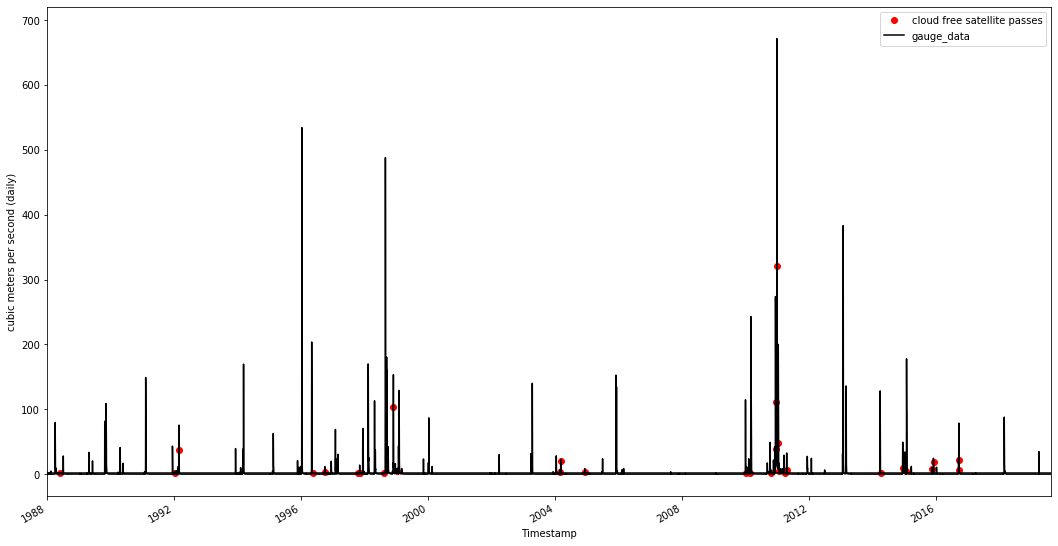

In [8]:
#Plot the clear satellite passes over the hydrograph
ax = clear_gauge_time_interp.plot(marker = 'o', color='red', linestyle='None', figsize=(18,10))
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='black')
plt.axhline(low_flow_threshold, color='black') #putting a black line to show the chosen threshold
ax.legend(["cloud free satellite passes", "gauge_data"]);
plt.xlim([date_range[0], date_range[1]])

print("Here is the hydrograph displaying the chosen threshold and days for which there were clear satellite passes above this threshold.")

**At this point, check whether you think the `low_flow_threshold` is reasonable. If you want to change it, change the value above and re run these cells.**

## Separate the satellite passes by whether they occur on the rising or falling limb of the flood peak

### Analysis parameters

* `days_ahead`: e.g. 21. How many days in advance the algorithm checks for a rise or fall. Note that one day is not enough beacuse the data is too noisy to just do 1 day. 21 days is suggested, based on work done by the MDBA. E.g. setting `days_ahead` to 21 means that the algorithm will take day 0, and compare it against day 21. If day 21 is higher than day 0, then it's considered to be rising. 

In [10]:
days_ahead = 21

### Run the code to sort the satellite passes

In [11]:
#extract the flow rate values from the gauge data for the loop
gauge_data_values = gauge_data['Value']
gauge_data_values = gauge_data_values.where(gauge_data_values > low_flow_threshold)
gauge_data_values = gauge_data_values.dropna()
# drop the hours/min/sec from the timestamp
gauge_data_values.index = gauge_data_values.index.strftime('%Y-%m-%d')

rising_list = []
falling_list = []
# loop through all time minus the days_ahead variable
#so that we don't consider the most recent data that has not seen enough time pass
for i, value in enumerate(gauge_data_values[:len(gauge_data_values)-days_ahead]):
    if value < gauge_data_values[i+days_ahead]:
        rising_list.append(gauge_data_values.index[i])
    else:
        falling_list.append(gauge_data_values.index[i])
    
#Remove the hours/min/seconds from the date stamp - we only care about the day of observation, not time
satellite_pass_dates = clear_gauge_time_interp.index.strftime('%Y-%m-%d')
satellite_pass_dates_list = satellite_pass_dates.tolist()

pass_list = []
for ii, time in enumerate(satellite_pass_dates_list):
    pass_list.append(satellite_pass_dates_list[ii])
    
#match the date lists up to the satellite passes
rising_passes1 = set(rising_list) & set(pass_list)
rising_passes = list(rising_passes1)
falling_passes1 = set(falling_list) & set(pass_list)
falling_passes = list(falling_passes1)

# CONVERT BACK TO PANDAS DATAFRAME SO YOU CAN MAKE THE GRAPH:
# get rid of the timestamp on the date index so it can matched to the rising and falling dataframes later
clear_gauge_time_interp.index = pd.DatetimeIndex(clear_gauge_time_interp.index.date)
clear_gauge_time_interp.index.name = 'date'
clear_gauge_time_interp.index.strftime('%Y-%m-%d')

# Change the list of rising passes into a pandas dataframe with the date as the index
rising_passes_df = pd.DataFrame(rising_passes)
rising_passes_df.columns = ['date']
rising_passes_df['date'] = pd.to_datetime(rising_passes_df['date'])
rising_passes_df = rising_passes_df.set_index(['date'])
# Extract the values column from the merged data
rising_passes_df = rising_passes_df.join(clear_gauge_time_interp)

# And do the same for falling
falling_passes_df = pd.DataFrame(falling_passes)
falling_passes_df.columns = ['date']
falling_passes_df['date'] = pd.to_datetime(falling_passes_df['date'])
falling_passes_df = falling_passes_df.set_index(['date'])
# Extract the values column from the merged data
falling_passes_df = falling_passes_df.join(clear_gauge_time_interp)

#### Another quick plot to see how it's looking

number of rising passes(blue): 7
number of falling passes(red): 15


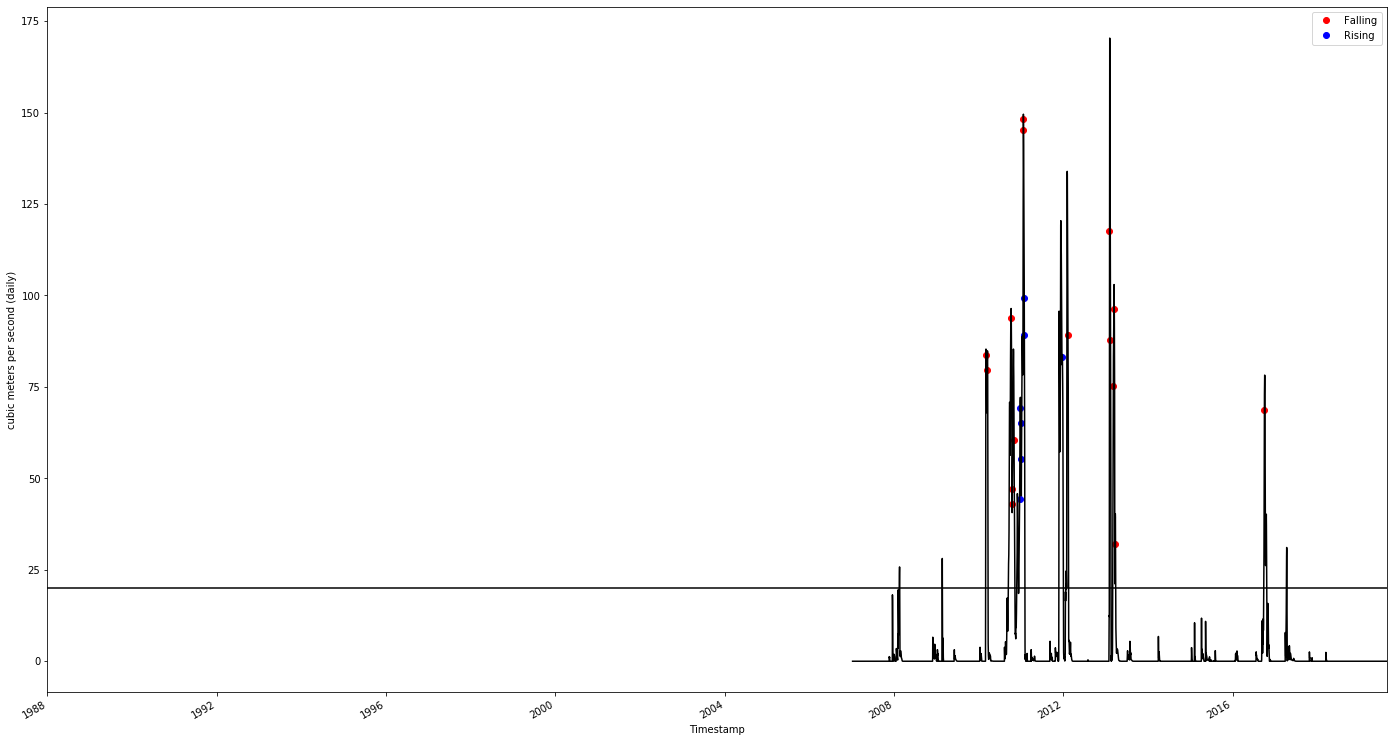

In [12]:
# Plot the rising and falling passes over the hydrograph
ax = falling_passes_df.plot(marker = 'o', color='red', linestyle='None', figsize=(24,14))
plt.ylabel('cubic meters per second (daily)')
rising_passes_df.plot(ax=ax, marker = 'o', color = 'blue', linestyle='None')
gauge_data.plot(ax=ax, color='black')
plt.axhline(low_flow_threshold, color='black') #putting a black line to show the chosen threshold
ax.legend(["Falling", "Rising"]);
plt.xlim([date_range[0], date_range[1]])

print(f"number of rising passes(blue): {len(rising_passes)}")
print(f"number of falling passes(red): {len(falling_passes)}")

## Calculate how many days each satellite pass is from the flood peak

In [13]:
#re-process the gauge data, but this time, don't drop the missing timesteps
#we want to keep the missing data since those values are below the threshold, and therefore valid as a falling data point
gauge_data_values = gauge_data['Value']
gauge_data_values = gauge_data_values.where(gauge_data_values > low_flow_threshold)
# drop the hours/min/sec from the timestamp
gauge_data_values.index = gauge_data_values.index.strftime('%Y-%m-%d')

# calculate the difference between subsequent observations to determine if the water is rising or falling
diffs = [y - x for x, y in zip(gauge_data_values, gauge_data_values[1:])]
# grab just the sign of the difference, so we have just 1 or -1 values
# 1 = rising hydrograph
# -1 = falling hydrograph
sign_diffs = np.sign(diffs)

In [14]:
# chuck the data back into a pandas dataframe
risingfalling = pd.DataFrame(index = gauge_data_values.index[1:], data = sign_diffs, columns = ['risingfalling'])

# We need to remove the NaNs from our data, but we want to assume that the most recent valid number continues
#missing data values are just where the gauge falls below the threshold, so we can assume they are valid falling data points
risingfallingfilled = risingfalling.ffill()

## Count how many days the hydrograph is rising/falling each time

### Analysis parameters

* `falling_days_min`: e.g. 100 (days). Set the number of days that the hydrograph needs to be falling prior to rising again to be considered in the analysis. This parameter allows you to remove flood peaks which fall and then re-flood again very quickly afterwards. If you are wanting to look at the longer-term patterns of water remaining on the flood plain after a flood peak, set this to be a larger threshold.
* `falling_days_max`: e.g. 100 (days). How many days after the flood peak to we actually care about? If this number is set to the same as `falling_days_min`, then we will only consider days up to our chosen threshold. If you want the flood to persist for at least x `falling_days_min`, but then you actually want to consider days beyond that threshold, set `falling_days_max` to a number larger than `falling_days_min`.

In [15]:
falling_days_min = 100
falling_days_max = 100

# Check that these parameters have been set correctly
assert (falling_days_min <= falling_days_max)

In [16]:
# Create an empty column in the dataframe to mark which peaks meet the falling_days criteria
risingfallingfilled['LongFalling'] = np.nan

# start the days counter
days = 0
for ix, timestep in enumerate(risingfallingfilled.risingfalling.values):
    # if the hydrograph is falling, increment the days
    if timestep == -1:
        days += 1
    else:
        # the hydrograph is rising and we don't care
        days = 0
    # if days reaches our minimum threshold...
    if days == falling_days_min:
        # grab the index for the start of the falling peak
        peak = ix - falling_days_min
        # put the day number since the start of the peak in the dataframe
        risingfallingfilled['LongFalling'][peak:ix] = range(0,falling_days_min)
    # check whether too much time has past. If we're still interested, keep labelling the data
    elif days > falling_days_min and days < falling_days_max:
        risingfallingfilled['LongFalling'][ix] = days

In [17]:
# get rid of all the hydrograph data we don't care about
just_relevant_peaks = risingfallingfilled.dropna(subset=['LongFalling'])
just_relevant_peaks.index = pd.to_datetime(just_relevant_peaks.index)

### Do a quick plot of all the falling hydrograph data together

In [18]:
# Find the satellite data that occurrs during the chosen flood peaks
combined_falling = clear_loaded_wofls.reindex(time=just_relevant_peaks.index,
                                                        method='nearest',tolerance=np.timedelta64(1,'D'))

wet_data = (combined_falling == 128).sum(dim='time')
dry_data = (combined_falling == 0).sum(dim='time')
clear_data = wet_data + dry_data
frequency_wet_data = wet_data / clear_data
frequency_wet_data = frequency_wet_data.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_wet_data = frequency_wet_data.where(frequency_wet_data!=0) #This is to tell it to make areas that were dry 100% of the time white

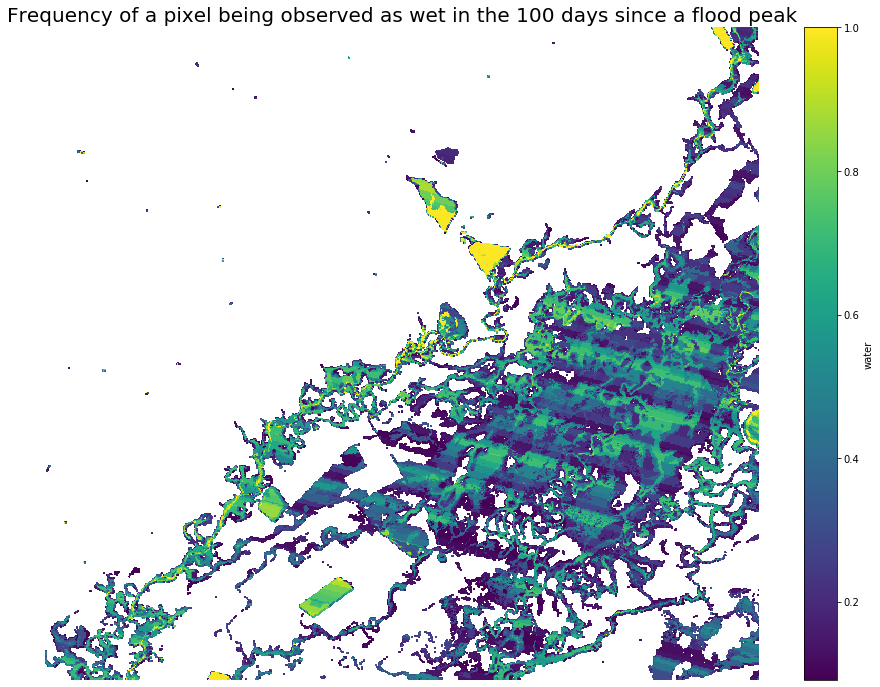

In [19]:
frequency_wet_data.plot(figsize = (16, 12))
plt.axis('off')
plt.title(f'Frequency of a pixel being observed as wet in the {falling_days_max} days since a flood peak', fontsize=20);

## <font color='red'>**3.	Bin the “after” images into days-after ranges (e.g. 5-10 days after peak, 10-20 days after peak and so on)** </font>
    
## <font color='red'>**4.	Graph each “days since inundation” (noting we can use the geotiffs for further spatial analyses)**</font>

In [20]:
# How do you want to group the data?
bin_size = 10

In [21]:
bin_ends = range(0,falling_days_max,bin_size)

for i,k in zip(bin_ends[0::1], bin_ends[1::1]):
    grouped_days = just_relevant_peaks.where((just_relevant_peaks['LongFalling'] > i) & (just_relevant_peaks['LongFalling'] <= k)).dropna()
    
    # Find the satellite data that occurrs during the chosen flood peaks
    combined_falling = clear_loaded_wofls.reindex(time=grouped_days.index,
                                                            method='nearest',tolerance=np.timedelta64(1,'D'))

    wet_data = (combined_falling == 128).sum(dim='time')
    dry_data = (combined_falling == 0).sum(dim='time')
    clear_data = wet_data + dry_data
    frequency_wet_data = wet_data / clear_data
    frequency_wet_data = frequency_wet_data.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
    frequency_wet_data = frequency_wet_data.where(frequency_wet_data!=0) #This is to tell it to make areas that were dry 100% of the time white
    print(i, wet_data.max())
    
#     frequency_wet_data.plot(figsize = (16, 12))
#     plt.axis('off')
#     plt.title(f'Frequency of a pixel being observed as wet in the {i} to {k} days since a flood peak', fontsize=20);
#     plt.savefig(f'{station.name.replace(" ", "")}{i}to{k}days.jpeg')
    
#     # Save the output to Geotiff
#     # Set up the file for writing
#     frequency_dataset = frequency_wet_data.to_dataset()
#     frequency_dataset.attrs=wofs_albers.attrs

#     break
#     # Write GeoTIFF to a location
#     write_geotiff(f'{station.name.replace(" ", "")}{i}to{k}days.tif', frequency_dataset)
    
#     plt.close()

0 <xarray.DataArray 'water' ()>
array(8)
10 <xarray.DataArray 'water' ()>
array(0)
20 <xarray.DataArray 'water' ()>
array(0)
30 <xarray.DataArray 'water' ()>
array(0)
40 <xarray.DataArray 'water' ()>
array(0)
50 <xarray.DataArray 'water' ()>
array(0)
60 <xarray.DataArray 'water' ()>
array(0)
70 <xarray.DataArray 'water' ()>
array(0)
80 <xarray.DataArray 'water' ()>
array(0)
